https://machinelearningmastery.com/what-is-bayesian-optimization/

Bayesian optimization is a powerful strategy for finding the extrema of objective functions that are expensive to evaluate. 

Hyperparameter tuning is a good fit for Bayesian Optimization because the evaluation function is computationally expensive (e.g. training models for each set of hyperparameters) and noisy (e.g. noise in training data and stochastic learning algorithms).

The Bayesian Optimization algorithm can be summarized as follows:

1. Select a Sample by Optimizing the Acquisition Function.
2. Evaluate the Sample With the Objective Function.
3. Update the Data and, in turn, the Surrogate Function.
4. Go To 1.

## An test example

In [13]:
# example of a gaussian process surrogate function
from math import sin
from math import pi
import numpy as np
import matplotlib.pyplot as plt
from warnings import catch_warnings
from warnings import simplefilter
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm

Optima: x=0.900, y=0.810


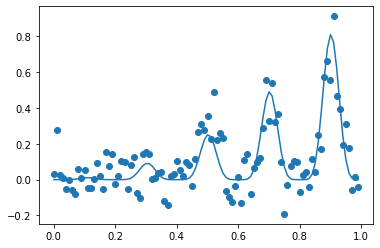

In [4]:
# objective function
def objective(x, noise=0.1):
	noise = normal(loc=0, scale=noise)
	return (x**2 * sin(5 * pi * x)**6.0) + noise

# grid-based sample of the domain [0,1]
X = np.arange(0, 1, 0.01)
# sample the domain without noise
y = [objective(x, 0) for x in X]
# sample the domain with noise
ynoise = [objective(x) for x in X]
# find best result
ix = np.argmax(y)
print('Optima: x=%.3f, y=%.3f' % (X[ix], y[ix]))
# plot the points with noise
plt.scatter(X, ynoise)
# plot the points without noise
plt.plot(X, y)
# show the plot
plt.show()

In [8]:
# surrogate or approximation for the objective function
def surrogate(model, X):
	# catch any warning generated when making a prediction
	with catch_warnings():
		# ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True)

In [9]:
# plot real observations vs surrogate function
def plot(X, y, model):
	# scatter plot of inputs and real objective function
	plt.scatter(X, y)
	# line plot of surrogate function across domain
	Xsamples = np.asarray(arange(0, 1, 0.001))
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	ysamples, _ = surrogate(model, Xsamples)
	plt.plot(Xsamples, ysamples)
	# show the plot
	plt.show()

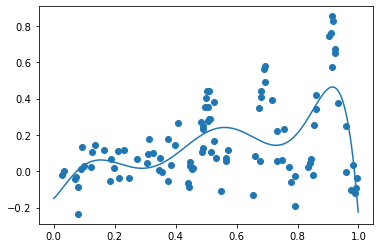

In [10]:
# sample the domain sparsely with noise
X = np.random.random(100)
y = np.asarray([objective(x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot the surrogate function
plot(X, y, model)

In [14]:
# probability of improvement acquisition function
def acquisition(X, Xsamples, model):
	# calculate the best surrogate score found so far
	yhat, _ = surrogate(model, X)
	best = max(yhat)
	# calculate mean and stdev via surrogate function
	mu, std = surrogate(model, Xsamples)
	mu = mu[:, 0]
	# calculate the probability of improvement
	probs = norm.cdf((mu - best) / (std+1E-9))
	return probs

# optimize the acquisition function
def opt_acquisition(X, y, model):
	# random search, generate random samples
	Xsamples = np.random.random(100)
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	# calculate the acquisition function for each sample
	scores = acquisition(X, Xsamples, model)
	# locate the index of the largest scores
	ix = np.argmax(scores)
	return Xsamples[ix, 0]

# perform the optimization process
for i in range(100):
	# select the next point to sample
	x = opt_acquisition(X, y, model)
	# sample the point
	actual = objective(x)
	# summarize the finding for our own reporting
	est, _ = surrogate(model, [[x]])
	print('>x=%.3f, f()=%3f, actual=%.3f' % (x, est, actual))
	# add the data to the dataset
	X = np.vstack((X, [[x]]))
	y = np.vstack((y, [[actual]]))
	# update the model
	model.fit(X, y)

>x=0.986, f()=0.005251, actual=0.045
>x=0.540, f()=0.237625, actual=0.010
>x=0.915, f()=0.462813, actual=0.699
>x=0.061, f()=-0.025422, actual=0.107
>x=0.413, f()=0.106743, actual=-0.076
>x=0.694, f()=0.149775, actual=0.215
>x=0.190, f()=0.054971, actual=0.061
>x=0.914, f()=0.479028, actual=0.554
>x=0.841, f()=0.324668, actual=-0.002
>x=0.036, f()=-0.059020, actual=0.099
>x=0.917, f()=0.472811, actual=0.600
>x=0.915, f()=0.480745, actual=0.928
>x=0.458, f()=0.159386, actual=0.087
>x=0.916, f()=0.506989, actual=0.597
>x=0.848, f()=0.349504, actual=0.096
>x=0.423, f()=0.107831, actual=-0.077
>x=0.125, f()=0.062779, actual=0.198
>x=0.918, f()=0.505041, actual=0.769
>x=0.657, f()=0.174368, actual=0.055
>x=0.524, f()=0.221421, actual=0.145
>x=0.542, f()=0.227895, actual=0.174
>x=0.924, f()=0.516775, actual=0.754
>x=0.918, f()=0.531046, actual=0.674
>x=0.919, f()=0.537836, actual=0.381
>x=0.851, f()=0.358202, actual=0.270
>x=0.336, f()=0.008281, actual=-0.027
>x=0.508, f()=0.206796, actual=0

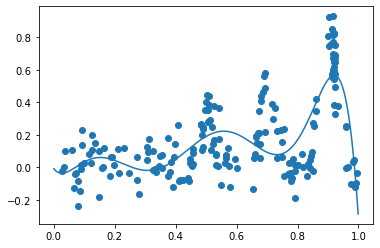

Best Result: x=0.915, y=0.928


In [16]:
# plot all samples and the final surrogate function
plot(X, y, model)
# best result
ix = np.argmax(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))

## with skopt (scikit-optimize)

In [17]:
# example of bayesian optimization with scikit-optimize
from numpy import mean
from sklearn.datasets import make_blobs
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from skopt.space import Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

# generate 2d classification dataset
X, y = make_blobs(n_samples=500, centers=3, n_features=2)
# define the model
model = KNeighborsClassifier()
# define the space of hyperparameters to search
search_space = [Integer(1, 5, name='n_neighbors'), Integer(1, 2, name='p')]

# define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):
	# something
	model.set_params(**params)
	# calculate 5-fold cross validation
	result = cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring='accuracy')
	# calculate the mean of the scores
	estimate = mean(result)
	return 1.0 - estimate

# perform optimization
result = gp_minimize(evaluate_model, search_space)
# summarizing finding:
print('Best Accuracy: %.3f' % (1.0 - result.fun))
print('Best Parameters: n_neighbors=%d, p=%d' % (result.x[0], result.x[1]))

C:\ProgramData\Anaconda3\envs\courses\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\ProgramData\Anaconda3\envs\courses\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\ProgramData\Anaconda3\envs\courses\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\ProgramData\Anaconda3\envs\courses\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\ProgramData\Anaconda3\envs\courses\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  

Best Accuracy: 0.860
Best Parameters: n_neighbors=4, p=1
